As it is difficult to test the accuracy of the algorithm in the Los Alamos dataset, we will create a artificial dataset for this purpose. A mixture of distributions will denote the possible states each host can be part of for each individual epoch. 

A set of different clusters of hosts will be created. Each set will have hosts, whose points are generated through the same transition matrices.

First we define the states that each data points can be part of. We will use a two dimensional space and a total of 7 total distributions.

In [1]:
import numpy as np

lambdas = np.vstack([[0,0], [15,20], [37,12], [7,48], [55,75], [30,40], [35,25]])
# set the weights of each distributions the same
weights = np.array([1/len(lambdas)] * len(lambdas))

# get random samples from these distributions
# number of points to take from each distribution centroid
size = 1000

for i, lambda_i in enumerate(lambdas):
    s1 = np.random.poisson(lambda_i[0], size)
    s2 = np.random.poisson(lambda_i[1], size)

    if i == 0:
        data = np.column_stack((s1, s2, np.array([i]*size, dtype=object)))
    else:
        data = np.append(data, np.column_stack((s1, s2, np.array([i]*size, dtype=object))), axis=0)

np.random.shuffle(data)

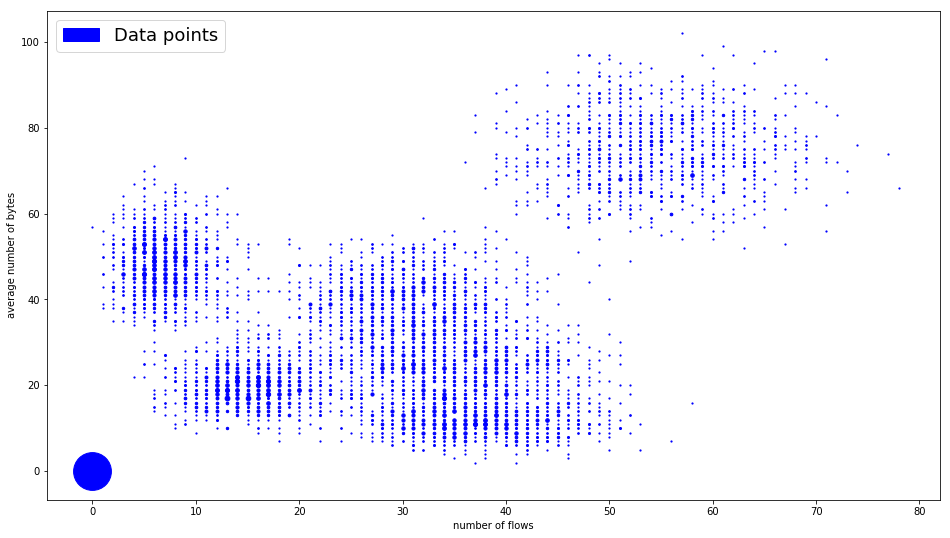

In [2]:
from plots import plot_points
%matplotlib inline

plot_points(data[:, :2])

As we can see most of these cluster are clearly seperated. Some of them are not. This is done on purpose to simulate a real example. From the random samples generated above, we can found the probability that a random sample has the maximum mass function value, for the distribution it originated from.

Let K be the total number of the distributions and J the total number of features we are considering (in our case 2).

Then for the $i^{th}$ sample drawn from the distribution k, the most likely distribution it originated from would be:

$$k_i = \underset{k}{\operatorname{argmax}} f(x_i, l_k)$$

where $$f(x_i, l_k) = \prod_{j=1}^J \frac{(l_{kj})^{x_{ij}} e^{-l_{kj}}}{x_{ij}!}$$

In [3]:
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

predictions = []
true_classes = []
for point in data:
    classification = np.argmax([poisson(point[:2], lambda_i) for lambda_i in lambdas])
    predictions.append(classification)
    true_classes.append(point[2])

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['class ' + str(i) for i in range(len(lambdas))]
print('confusion_matrix: ')
print(confusion_matrix(true_classes, predictions))

print()
print()
print(classification_report(true_classes, predictions, target_names=target_names))

confusion_matrix: 
[[1000    0    0    0    0    0    0]
 [   0  980    3    4    0    1   12]
 [   0    9  928    0    0    0   63]
 [   0    1    0  998    0    1    0]
 [   0    0    0    0  997    3    0]
 [   0    8    0    3    1  912   76]
 [   0   14   69    0    0   85  832]]


             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      1000
    class 1       0.97      0.98      0.97      1000
    class 2       0.93      0.93      0.93      1000
    class 3       0.99      1.00      1.00      1000
    class 4       1.00      1.00      1.00      1000
    class 5       0.91      0.91      0.91      1000
    class 6       0.85      0.83      0.84      1000

avg / total       0.95      0.95      0.95      7000



Now we will create the clusters of the transition matrices.

We will create a number of clusters containing different number of hosts each to stimulate a real example.

The parameter L denotes the total number of these matrices clusters.

In [331]:
import random as ran

L = 12
num_hosts_per_L = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 80, 150]

def random_vector(size=7):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=7):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [332]:
transition_matrices = []
for i in range(L):
    transition_matrices.append(random_transition_matrix(size=len(lambdas)))

Create the points for each individual host.

Each host, for the first epoch, has a datapoints at a random distribution. The next datapoint will belong to a new distribution depending on a roulette wheel mechanism and the transition probabilities of the cluster the host belongs to.

In [333]:
data_points = []
number_of_epochs = 500

# creates a random data point for a specified distribution and adds it to the total data points
def add_random_points(data_points, host_name, distribution, lambdas, epoch):
    axis0 = np.random.poisson(lambdas[distribution][0], 1)[0]
    axis1 = np.random.poisson(lambdas[distribution][1], 1)[0]
    data_points.append([axis0, axis1, epoch, host_name])

def random_next_state(transition_matrices, i, previous_distribution):
    r = ran.random()
    return np.where(transition_matrices[i][previous_distribution].cumsum() >= r)[0][0]
    
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        # random starting distribution
        previous_distribution = ran.randint(0, len(lambdas) - 1)
        add_random_points(data_points, host_name, previous_distribution, lambdas, 1)
        
        for k in range(2, number_of_epochs + 1):
            next_distribution = random_next_state(transition_matrices, i, previous_distribution)
            
            add_random_points(data_points, host_name, next_distribution, lambdas, k)
            
            previous_distribution = next_distribution
            

data_points = np.array(data_points,  dtype=object)

Run the EM Algorithm and the clustering

An important note is that initial EM mixtures center points, might have some differences to the desired final points, so on the starting epochs some of the results might not be the desired ones. This should not be a problem though.

In [334]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

Select some random data points as the initial ones.

In [335]:
mixtures = len(lambdas)

kplusplus = KPlusPlus(mixtures, data_points[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7


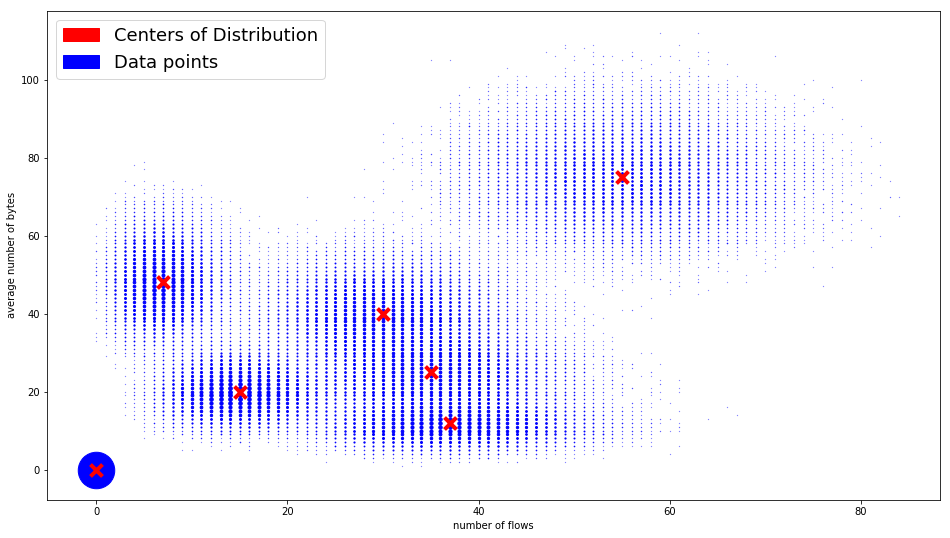

In [336]:
#onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, sum(num_hosts_per_L), verbose=0, update_power=0.5)
onlineEM = OnlineEM([1/mixtures]*mixtures, lambdas, sum(num_hosts_per_L), verbose=0, update_power=0.5)

# the initial data points
plot_points(data_points[:, :2], onlineEM)

In [337]:
onlineEM.fit(data_points[:,[0,1,3]])

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:205: RuntimeWarning: invalid value encountered in true_divide
  previous)
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


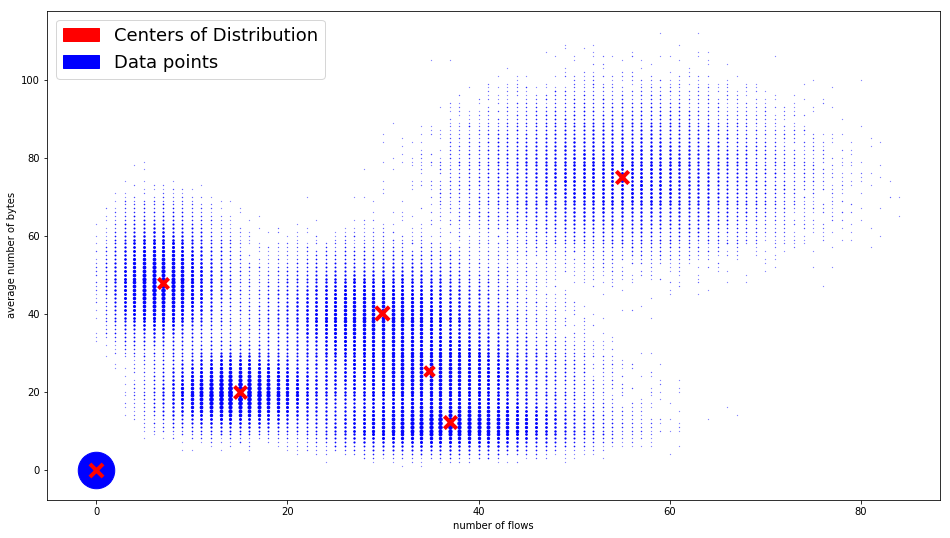

In [338]:
# the finadl data points
plot_points(data_points[:, :2], onlineEM)

In [339]:
print(onlineEM.gammas)
print(onlineEM.lambdas)

[ 0.17107522  0.14585168  0.15168108  0.10509689  0.15285642  0.17999667
  0.09344205]
[[0.0 0.0]
 [15.021556691068064 19.992128910728695]
 [36.986591547234326 12.077769262773094]
 [7.0227197696084431 47.953750147428828]
 [54.997060910565196 75.062306936821457]
 [29.853164000249958 40.094199506854842]
 [34.807008057635471 25.208899011604725]]


The transition matrices will be initialized to the following table (normalized to 1):

initializer:

|  |
| :-------------: |:-------------:| :-----:|
| 1  | 0.5 | ... | 0.5 | 
| 0.5  | 1 | ... | 0.5 | 
| ...  | ... | ... | .. | 
| 0.5  | 0.5 | ... | 1 | 


The final transition matrix will be:

$$\frac{initializer}{num\_points + 1} + \frac{transition\_matrix * num\_points}{num\_points + 1}$$ for each individual row.

This is done manually in the following cells but in the final version of the algorithm will be done automatically

In [340]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [341]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

Now we can cluster the transition matrices.

In [342]:
from klkmeans import kl_kMeans

kmeans = kl_kMeans(onlineEM, n_clusters=L, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run()

Starting run
The cost is 147.900633883


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\klkmeans.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  total_distance += P[i] * log(P[i]/Q[i])


The cost is 78.2320786438
The cost is 60.6904304896
The cost is 57.7060233496
The cost is 57.6390893971
converged
Starting run
The cost is 124.839108149
The cost is 86.8280168859
The cost is 80.5803976992
The cost is 80.5458325343
The cost is 80.514431792
The cost is 80.4914144387
The cost is 80.4849558197
The cost is 80.4649592601
The cost is 80.4495174054
The cost is 80.4476053477
converged
Starting run
The cost is 128.166255415
The cost is 84.9020271465
The cost is 76.3251283807
The cost is 75.4601708196
The cost is 71.2277793413
The cost is 70.3933546784
The cost is 70.3733207732
The cost is 70.3632750995
The cost is 70.3392402475
The cost is 70.3234819781
The cost is 70.3031080311
The cost is 70.2861247869
The cost is 70.2785193716
converged
Starting run
The cost is 106.215321008
The cost is 75.721709831
The cost is 75.6751875342
The cost is 75.6163198212
The cost is 75.5056113137
The cost is 74.6947006349
The cost is 73.3628105818
converged
Starting run
The cost is 87.3067485916


In [343]:
centroids = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = assign[host_name]
        centroids[i][participation] += 1
    
print(centroids)

[[  0   0   0   0   0   0   0   0   0  10   0   0]
 [  0   0   0   0   0   0   0   0  15   0   0   0]
 [  0   0   0   0   0  20   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  25   0   0]
 [  0   0   0  30   0   0   0   0   0   0   0   0]
 [  0  35   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  40   0   0   0   0   0]
 [  0   0   0   0   0   0   0  45   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  50]
 [  0   0   0   0   0   0   0   0   0   0  60   0]
 [ 80   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  39   0 111   0   0   0   0   0   0   0]]


Calculate the Purity

$$ Purity = \frac{1}{N} \sum_{i=1}^k max_j |c_i ∩ t_j|$$

where $c_i$ is the class the host belongs to and $t_j$ the cluster it was assigned to

We will also use a number of different metrics

In [355]:
from sklearn.metrics.cluster import normalized_mutual_info_score, homogeneity_score, completeness_score, adjusted_rand_score
from math import log

def calculate_purity(centroids):
    total_points = np.sum(centroids)
    pure = np.sum(np.max(centroids, axis=0))
    return pure/total_points 
    
def calculate_entropy(centroids):
    total_entropy = 0
    
    total_points_in_clusters = np.sum(centroids, axis=0)
    total_points = np.sum(centroids)
    for i in range(len(centroids)):
        entropy = 0
        for j in range(len(centroids)):
            if centroids[j][i] == 0:
                continue
            percentage_of_class_in_cluster = centroids[j][i] / total_points_in_clusters[i]
            entropy -= percentage_of_class_in_cluster * log(percentage_of_class_in_cluster)
            
        total_entropy += entropy * total_points_in_clusters[i] / total
    return total_entropy
    
def cluster_quality(centroids):
    print('Entropy\t\t\t\t', calculate_entropy(centroids))
    print('Purity \t\t\t\t', calculate_purity(centroids))
    
    y_true = []
    y_pred = []
    for i in range(len(centroids)):
        for j in range(len(centroids)):
            for k in range(centroids[i][j]):
                y_true.append(i)
                y_pred.append(j)
    
    print('Normalized_mutual_info_score\t', normalized_mutual_info_score(y_true, y_pred))
    print('Rand index adjusted for chance\t', adjusted_rand_score(y_true, y_pred))
    print('homogeneity_score\t\t', homogeneity_score(y_true, y_pred))
    print('completeness_score\t\t', completeness_score(y_true, y_pred))

In [356]:
cluster_quality(centroids)

Entropy				 0.0805362907711
Purity 				 0.982142857143
Normalized_mutual_info_score	 0.958660371754
Rand index adjusted for chance	 0.861373707997
homogeneity_score		 0.98326002368
completeness_score		 0.934676165246


We will now compare this method to merely classifying hosts based on the clusters their data points can be found

For this case we will cluster the vectors containing for each host where their points can be located

In [357]:
participations = []
for host in onlineEM.hosts:
    participations.append(onlineEM.hosts[host]['points_per_cluster'])

In [358]:
from sklearn.cluster import KMeans

kmeans_points = KMeans(n_clusters=L, random_state=0).fit(participations)

In [359]:
centroids_points = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = kmeans_points.predict([onlineEM.hosts[host_name]['points_per_cluster']])[0]
        centroids_points[i][participation] += 1
    
print(centroids_points)

[[ 0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  1  0  2]
 [ 0  0  0  0  0  0  0 19  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 25  0]
 [ 0  4  1  0  0  0  0  0 25  0  0  0]
 [35  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 36  0  0  0  0  3]
 [ 1 41  1  0  0  0  1  0  1  0  0  0]
 [ 0  1 45  0  0  0  0  1  2  0  1  0]
 [ 0  3  0  0  0  0  6  0  0  0  0 51]
 [ 0  0  0  0 79  0  0  0  0  0  0  1]
 [ 1  0  0 48  0 43  0  0  0 58  0  0]]


In [360]:
cluster_quality(centroids_points)

Entropy				 0.68268253154
Purity 				 0.901785714286
Normalized_mutual_info_score	 0.82144472102
Rand index adjusted for chance	 0.651329862562
homogeneity_score		 0.858100127249
completeness_score		 0.786355121348
